It took 1.203125 seconds to complete the shading with a DT
It took 11.34375 seconds to complete the shading with kNN
DTs get faster compared to kNN as number of training points increases - set n = 500 and see


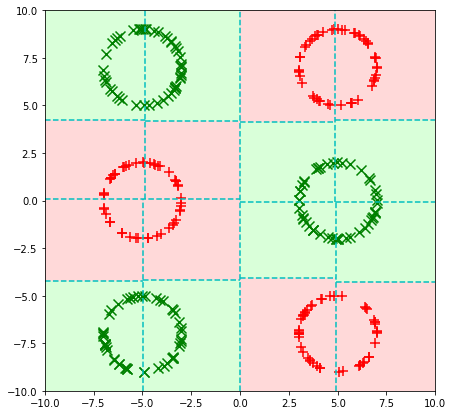

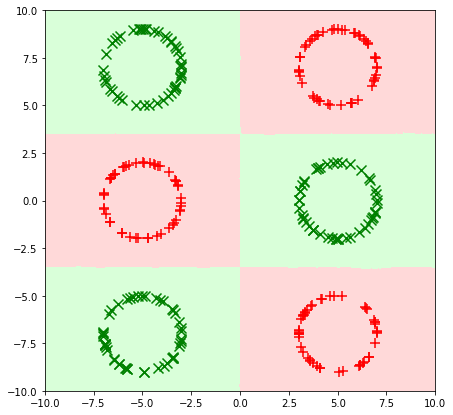

In [7]:
import numpy as np
from numpy import linalg as lin
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from matplotlib import pyplot as plt
import time as t

class Node:
    # A node stores its own depth (root = depth 0), its decision stump, its parent and child information
    # Leaf nodes also store a constant label that is assigned to every data point that reaches that leaf
    def __init__( self, depth = 0, stump = (0,0), parent = None ):
        self.depth = depth
        self.stump = stump
        self.parent = parent
        self.left = None
        self.right = None
        self.isLeaf = True
        self.label = 0
        
    def predict( self, data ):
        # If I am a leaf I can predict rightaway
        # May change this constant leaf action to something more interesting and powerful
        if self.isLeaf:
            return self.label
        # Else I have to ask one of my children to do the job
        else:
            if data[self.stump[0]] > self.stump[1]:
                return self.right.predict( data )
            else:
                return self.left.predict( data )
            
    # Get the Gini coefficient of a node with nPos positive points and nNeg negative points
    def getGini( self, nPos, nNeg ):
        nTot = nPos + nNeg
        # Find the proportion of the positives and negatives in that node
        pPos = nPos/nTot
        pNeg = nNeg/nTot
        # The gini index is always a real number between 0 and 0.5
        # A perfectly pure node has gini index = 0
        # The smaller the gini index the purer the node
        gini = 1 - (pPos**2 + pNeg**2)
        return gini
    
    # Get the balance factor of a certain split that sends nLeft and nRight data points to left and right child
    def getBalance( self, nLeft, nRight ):
        # There are several other possible notions of balance as well
        # This one will always return a positive number (which can be arbitrarily large)
        # A perfectly balanced split has balance factor 0
        # The smaller the balance factor the more balanced the split
        balance = max(nLeft, nRight)/min(nLeft, nRight) - 1
        return balance
        
    def getStump( self, X, y ):
        # How many data points do I have at this node?
        n = y.size
        bestObjective = float('inf')
        
        # For each of the features in the data
        for i in range( X.shape[1] ):
            # Do not use the same feature as used by the parent node
            if self.parent is not None and i == self.parent.stump[0]:
                continue
            # Find out all values at which we can threshold that feature
            candidateThresholds = np.sort( X[:, i] )
            idx = np.argsort( X[:, i] )
            # The cumulative sum trick used here will work only if labels are binary :)
            ySorted = y[idx]
            yCum = np.cumsum( ySorted )
            yCumRev = np.cumsum( ySorted[::-1] )[::-1]
            # For each possible threshold (except the ones at the extreme)
            for j in range( 1, candidateThresholds.size-1 ):
                # Give 0.5 weight to balance and 1 weight to purity of the two nodes
                candidateObjective = 0.5 * self.getBalance( j+1, n-j-1 ) \
                                    + 0.0 * self.getGini( (yCum[j] + j+1)/2, (j+1 - yCum[j])/2 ) \
                                    + 0.0 * self.getGini( (yCumRev[j+1] + n-j-1)/2, (n-j-1 - yCumRev[j+1])/2 )
                if candidateObjective < bestObjective:
                    bestObjective = candidateObjective
                    bestFeat = i
                    bestThresh = candidateThresholds[j]
        
        # Can try LwP decision stump as well
        bestThresh = (np.mean(X[y > 0, bestFeat]) + np.mean(X[y < 0, bestFeat]))/2
        return (bestFeat, bestThresh)
            
    def train( self, X, y, maxLeafSize, maxDepth ):
        # If too few data points are present, or else if this node is too deep in the tree, make this a leaf
        if y.size < maxLeafSize or self.depth >= maxDepth:
            self.isLeaf = True
            self.label = np.mean( y )
        else:
            # This node will be split and hence it is not a leaf
            self.isLeaf = False
            # Get the best possible decision stump
            self.stump = self.getStump( X, y )
            self.left = Node( depth = self.depth + 1, parent = self )
            self.right = Node( depth = self.depth + 1, parent = self )
            # Find which points go to my left child and which go to my right child
            discriminant = X[:, self.stump[0]] - self.stump[1]
            # Train my two children recursively
            self.left.train( X[discriminant <= 0, :], y[discriminant <= 0], maxLeafSize, maxDepth )
            self.right.train( X[discriminant > 0, :], y[discriminant > 0], maxLeafSize, maxDepth )

class Tree:
    def __init__( self, maxLeafSize = 10, maxDepth = 5 ):
        self.root = Node()
        self.maxLeafSize = maxLeafSize
        self.maxDepth = maxDepth 
        
    def predict( self, xt, yt ):
        return self.root.predict( np.array( [xt, yt] ) )
    
    def train( self, X, y ):
        self.root.train( X, y, self.maxLeafSize, self.maxDepth )

d = 2 
n = 50
r = 2

tmp1 = gsd.genSphericalData( d, n, [-5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [-5, 7], r )
XPos = np.vstack( (tmp1, tmp2, tmp3) )
yPos = np.ones( (3*n,) )

tmp1 = gsd.genSphericalData( d, n, [5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [-5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [5, 7], r )
XNeg = np.vstack( (tmp1, tmp2, tmp3) )
yNeg = -np.ones( (3*n,) )

X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

DT = Tree( maxLeafSize = 5, maxDepth = 4 )
DT.train( X, y )

def drawTreeSplits( node, fig, xlim, ylim ):
    if not node.isLeaf:
        plt.figure( fig.number )
        # Is this a vertical split or a horizontal one?
        if node.stump[0] == 0:
            plt.plot( [node.stump[1], node.stump[1]], ylim, color = 'c', linestyle = '--' )
            drawTreeSplits( node.left, fig, [xlim[0], node.stump[1]], ylim )
            drawTreeSplits( node.right, fig, [node.stump[1], xlim[1]], ylim )
        elif node.stump[0] == 1:
            plt.plot( xlim, [node.stump[1], node.stump[1]], color = 'c', linestyle = '--' )
            drawTreeSplits( node.left, fig, xlim, [ylim[0], node.stump[1]] )
            drawTreeSplits( node.right, fig, xlim, [node.stump[1], ylim[1]] )
            
def kNNClass( xt, yt ):
    diff = X - np.array( [xt, yt] )
    dist = lin.norm( diff, axis = 1 )
    idx = np.argsort( dist )
    yhat = 0
    wsum = 0
    for i in range( k ):
        yhat = yhat + y[idx[i]]
    return yhat/k

fig = pd.getFigure()
tic = t.process_time()
pd.shade2D( DT.predict, fig, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete the shading with a DT")
drawTreeSplits(DT.root, fig, xlim = [-10, 10],  ylim = [-10, 10])
pd.plot2D( XNeg, fig, color = 'r', marker = '+' )
pd.plot2D( XPos, fig, color = 'g', marker = 'x' )

k = 1
fig2 = pd.getFigure()
tic = t.process_time()
pd.shade2D( kNNClass, fig2, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete the shading with kNN")
pd.plot2D( XNeg, fig2, color = 'r', marker = '+' )
pd.plot2D( XPos, fig2, color = 'g', marker = 'x' )
print( "DTs get faster compared to kNN as number of training points increases - set n = 500 and see" )